In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib
from sklearn.cluster import KMeans

import common.loss_utils as loss_utils

import sys
sys.path.append('utae-paps')
from src.backbones import utae_mod

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
FORECAST = 23
NUM_CLASSES = 81

model = utae_mod.UTAE(
    input_dim=1, # 10 for paper
    forecast_steps=FORECAST,
    encoder_widths=[32, 64, 64, 128],
    decoder_widths=[32, 32, 64, 128],
    out_conv=[32, NUM_CLASSES],
    str_conv_k=4,
    str_conv_s=2,
    str_conv_p=1,
    agg_mode="att_group",
    encoder_norm="group",
    n_head=16,
    d_model=256,
    d_k=4,
    encoder=False,
    return_maps=False,
    pad_value=None, # 0
    padding_mode="reflect",
)
model = model.to(DEVICE)

In [5]:
_MEDIAN_PIXEL = 216.0
_IQR = 201.0

deltas = np.linspace(-2.0, 2.0, num=81).astype(np.float32)
_cluster_centers = deltas.reshape(-1,1)

_KM = KMeans()
_KM.cluster_centers_ = _cluster_centers
_KM._n_threads = 1

def transform(x):
    return np.tanh((x - _MEDIAN_PIXEL) / _IQR)

def transform_y(y, starter):
    y = transform(y)
    y = y - starter
    y_grouped = _KM.predict(y.reshape(-1,1))
    y_grouped = y_grouped.reshape(y.shape)
    return y_grouped

In [6]:
p = pathlib.Path('climatehack-submission/features.npz')
t = pathlib.Path('climatehack-submission/targets.npz')
feats = np.load(p)
targs = np.load(t)

In [7]:
x = feats['data']
y = targs['data']

In [8]:
x.shape, y.shape

((200, 12, 128, 128), (200, 24, 64, 64))

In [9]:
# grab a sample
xi = x[:1]
yi = y[:1]

xi = transform(xi)
x_last = xi[:,-1]
xi = xi - x_last
yi = transform_y(yi[:,:FORECAST], x_last[:,32:96,32:96])
xi = torch.FloatTensor(xi).to(DEVICE)
yi = torch.LongTensor(yi).to(DEVICE)

xi = torch.unsqueeze(xi, dim=2)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

In [11]:
TRIES = 1000

pbar = tqdm.tqdm(range(TRIES))
for _ in pbar:
    optimizer.zero_grad()
    preds = model(xi)
    b, t, k, w, h = preds.shape
    preds_flat = preds.reshape(b*t, k, w, h)
    yi_flat = yi.reshape(b*t, w, h)
    loss = criterion(preds_flat, yi_flat)
    loss.backward()
    optimizer.step()
    
    l = round(loss.item(), 4)
    pbar.set_description(f"Loss: {l}")

  0%|          | 0/1000 [00:00<?, ?it/s]

STEP 0
STEP 1
STEP 2
STEP 3
STEP 4
STEP 5
STEP 6
STEP 7
STEP 8
STEP 9
STEP 10
STEP 11
STEP 12
STEP 13
STEP 14
STEP 15
STEP 16
STEP 17
STEP 18
STEP 19
STEP 20
STEP 21
STEP 22


Loss: 4.6164:   0%|          | 1/1000 [00:00<12:23,  1.34it/s]

STEP 0
STEP 1
STEP 2
STEP 3
STEP 4
STEP 5
STEP 6
STEP 7
STEP 8
STEP 9
STEP 10
STEP 11
STEP 12
STEP 13
STEP 14
STEP 15
STEP 16
STEP 17
STEP 18
STEP 19
STEP 20
STEP 21
STEP 22


Loss: 4.5248:   0%|          | 2/1000 [00:01<08:26,  1.97it/s]

STEP 0
STEP 1
STEP 2
STEP 3
STEP 4
STEP 5
STEP 6
STEP 7
STEP 8
STEP 9
STEP 10
STEP 11
STEP 12
STEP 13
STEP 14
STEP 15
STEP 16
STEP 17
STEP 18
STEP 19
STEP 20
STEP 21
STEP 22


Loss: 4.4584:   0%|          | 3/1000 [00:01<07:01,  2.36it/s]

STEP 0
STEP 1
STEP 2
STEP 3
STEP 4
STEP 5
STEP 6
STEP 7
STEP 8
STEP 9
STEP 10
STEP 11
STEP 12
STEP 13
STEP 14
STEP 15
STEP 16
STEP 17
STEP 18
STEP 19
STEP 20
STEP 21
STEP 22


Loss: 4.4208:   0%|          | 4/1000 [00:01<06:21,  2.61it/s]

STEP 0
STEP 1
STEP 2
STEP 3
STEP 4
STEP 5
STEP 6
STEP 7
STEP 8
STEP 9
STEP 10
STEP 11
STEP 12
STEP 13
STEP 14
STEP 15
STEP 16
STEP 17
STEP 18
STEP 19
STEP 20
STEP 21
STEP 22


Loss: 4.3925:   0%|          | 5/1000 [00:02<05:59,  2.76it/s]

STEP 0
STEP 1
STEP 2
STEP 3
STEP 4
STEP 5
STEP 6
STEP 7
STEP 8
STEP 9
STEP 10
STEP 11
STEP 12
STEP 13
STEP 14
STEP 15
STEP 16
STEP 17
STEP 18
STEP 19
STEP 20
STEP 21
STEP 22


Loss: 4.3754:   1%|          | 6/1000 [00:02<05:46,  2.86it/s]

STEP 0
STEP 1
STEP 2
STEP 3
STEP 4
STEP 5
STEP 6
STEP 7
STEP 8
STEP 9
STEP 10
STEP 11
STEP 12
STEP 13
STEP 14
STEP 15
STEP 16
STEP 17
STEP 18
STEP 19
STEP 20
STEP 21
STEP 22


Loss: 4.3475:   1%|          | 7/1000 [00:02<05:38,  2.94it/s]

STEP 0
STEP 1
STEP 2
STEP 3
STEP 4
STEP 5
STEP 6
STEP 7
STEP 8
STEP 9
STEP 10
STEP 11
STEP 12
STEP 13
STEP 14
STEP 15
STEP 16
STEP 17
STEP 18
STEP 19
STEP 20
STEP 21
STEP 22


Loss: 4.3121:   1%|          | 8/1000 [00:03<05:33,  2.98it/s]

STEP 0
STEP 1
STEP 2
STEP 3
STEP 4
STEP 5
STEP 6
STEP 7
STEP 8
STEP 9
STEP 10
STEP 11
STEP 12
STEP 13
STEP 14
STEP 15
STEP 16
STEP 17
STEP 18
STEP 19
STEP 20
STEP 21
STEP 22


Loss: 4.2921:   1%|          | 9/1000 [00:03<05:29,  3.01it/s]

STEP 0
STEP 1
STEP 2
STEP 3
STEP 4
STEP 5
STEP 6
STEP 7
STEP 8
STEP 9
STEP 10
STEP 11
STEP 12
STEP 13
STEP 14
STEP 15
STEP 16
STEP 17
STEP 18
STEP 19
STEP 20
STEP 21
STEP 22


Loss: 4.2693:   1%|          | 10/1000 [00:03<05:25,  3.04it/s]

STEP 0
STEP 1
STEP 2
STEP 3
STEP 4
STEP 5
STEP 6
STEP 7
STEP 8
STEP 9
STEP 10
STEP 11
STEP 12
STEP 13
STEP 14
STEP 15
STEP 16
STEP 17
STEP 18
STEP 19
STEP 20
STEP 21
STEP 22


Loss: 4.2551:   1%|          | 11/1000 [00:03<05:23,  3.05it/s]

STEP 0
STEP 1
STEP 2
STEP 3
STEP 4
STEP 5
STEP 6
STEP 7
STEP 8
STEP 9
STEP 10
STEP 11
STEP 12
STEP 13
STEP 14
STEP 15
STEP 16
STEP 17
STEP 18
STEP 19
STEP 20
STEP 21
STEP 22


Loss: 4.2256:   1%|          | 12/1000 [00:04<05:22,  3.06it/s]

STEP 0
STEP 1
STEP 2
STEP 3
STEP 4
STEP 5
STEP 6
STEP 7
STEP 8
STEP 9
STEP 10
STEP 11
STEP 12
STEP 13
STEP 14
STEP 15
STEP 16
STEP 17
STEP 18
STEP 19
STEP 20
STEP 21
STEP 22


Loss: 4.2225:   1%|▏         | 13/1000 [00:04<05:21,  3.07it/s]

STEP 0
STEP 1
STEP 2
STEP 3
STEP 4
STEP 5
STEP 6
STEP 7
STEP 8
STEP 9
STEP 10
STEP 11
STEP 12
STEP 13
STEP 14
STEP 15
STEP 16
STEP 17
STEP 18
STEP 19
STEP 20
STEP 21
STEP 22


Loss: 4.1961:   1%|▏         | 14/1000 [00:04<05:20,  3.08it/s]

STEP 0
STEP 1
STEP 2
STEP 3
STEP 4
STEP 5
STEP 6
STEP 7
STEP 8
STEP 9
STEP 10
STEP 11
STEP 12
STEP 13
STEP 14
STEP 15
STEP 16
STEP 17
STEP 18
STEP 19
STEP 20
STEP 21
STEP 22


Loss: 4.1961:   1%|▏         | 14/1000 [00:05<06:11,  2.65it/s]


KeyboardInterrupt: 

In [13]:
_means = torch.FloatTensor(_cluster_centers).to(DEVICE)
_means = torch.unsqueeze(torch.unsqueeze(_means, 0), 3)

def get_img(preds):
    class_dim = 2
    m = preds.max(dim=class_dim).values
    m = torch.unsqueeze(m, dim=class_dim)
    preds = preds - m
    a = torch.exp(preds)
    v = a.sum(dim=class_dim)
    e = a / torch.unsqueeze(v, class_dim)
    r = torch.sum(e * _means, axis=class_dim)
    return r

In [14]:
with torch.no_grad():
    preds = model(xi)

In [15]:
x_last_tensor = torch.FloatTensor(x_last).to(DEVICE)
preds = get_img(preds)
preds = preds + x_last_tensor[:,32:96,32:96]
preds[preds > 1] = 0.999
preds[preds < -1] = -0.999
preds = torch.atanh(preds) * _IQR + _MEDIAN_PIXEL

In [17]:
preds_np = preds.detach().cpu().numpy()

In [18]:
criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=FORECAST)


In [19]:
y_expected = torch.FloatTensor(y[:1,:FORECAST]).to(DEVICE)

In [20]:
criterion(preds,y_expected)

tensor(0.8185, device='cuda:0')

In [21]:
# looks at persistence as a benchmark
x_pers = torch.unsqueeze(x_last_tensor[:, 32:96, 32:96], dim=1)
x_pers = torch.tile(x_pers, (1, FORECAST, 1, 1))

In [22]:
criterion(x_pers,y_expected)

tensor(0.3977, device='cuda:0')

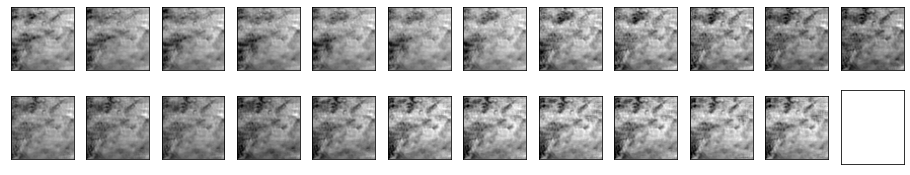

In [61]:
fig, (ax1, ax2) = plt.subplots(2, 12, figsize=(16,3))
for i in range(12):
    ax1[i].imshow(preds_np[0,i], cmap='gray')
    ax1[i].get_xaxis().set_visible(False)
    ax1[i].get_yaxis().set_visible(False)

for i in range(12):
    if i != 11:
        ax2[i].imshow(preds_np[0,12 + i], cmap='gray')
    ax2[i].get_xaxis().set_visible(False)
    ax2[i].get_yaxis().set_visible(False)

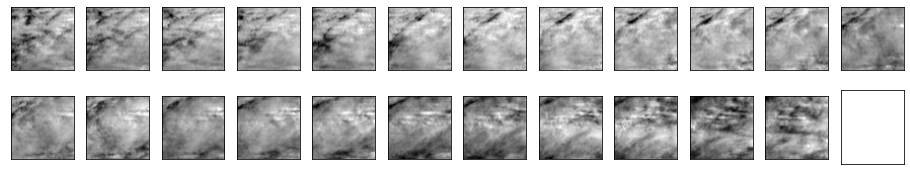

In [62]:
fig, (ax1, ax2) = plt.subplots(2, 12, figsize=(16,3))
for i in range(12):
    ax1[i].imshow(y[0,i], cmap='gray')
    ax1[i].get_xaxis().set_visible(False)
    ax1[i].get_yaxis().set_visible(False)

for i in range(12):
    if i != 11:
        ax2[i].imshow(y[0,12 + i], cmap='gray')
    ax2[i].get_xaxis().set_visible(False)
    ax2[i].get_yaxis().set_visible(False)